# Imports

In [2]:
import sklearn as sk
from sklearn import datasets as data
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from matplotlib import pyplot as plt
import numpy as np
import re
import calm
import gensim as gs
import os
import subprocess
import pickle
# formatting
from IPython.core.display import HTML
HTML("<style>.container { width:90% !important, }</style>")
%matplotlib inline

In [3]:
project_dir = '/home/matt/Git/TextMiningFinal/'
os.chdir(project_dir)
mallet_dir = '/home/matt/Git/Mallet/'
mallet_executable = './bin/mallet'
tokens_to_mallet_script = os.path.join('code','tokens_to_mallet.sh')

In [4]:
news_processor_configs = [filename for filename in os.listdir('config/processor') if (filename.endswith('.yml') and 'newsgroups' in filename)]
news_processor_configs = [os.path.join('config/processor',filename) for filename in news_processor_configs]
reuters_processor_configs = [filename for filename in os.listdir('config/processor') if (filename.endswith('.yml') and 'reuters' in filename)]
reuters_processor_configs = [os.path.join('config/processor',filename) for filename in reuters_processor_configs]

In [5]:
print(news_processor_configs)
print(reuters_processor_configs)

['config/processor/20_newsgroups_simple.yml', 'config/processor/20_newsgroups_complex.yml']
[]


## The newsgroups data, cleaned and munged, all in one line

In [6]:
newsgroups = data.fetch_20newsgroups(remove=('headers','footers'))

In [7]:
processor = calm.processor.Processor(news_processor_configs[0])

### inspect

In [6]:
type(newsgroups)

sklearn.datasets.base.Bunch

In [7]:
list(newsgroups.keys())

['target_names', 'target', 'filenames', 'DESCR', 'description', 'data']

In [8]:
len(newsgroups['data'])

11314

In [9]:
newsgroups['data'][0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'


## The reuters data

In [10]:
# if you don't have the reuters corpus installed, run nltk.download()
from nltk.corpus import reuters

# Write a bunch of MALLET corpora to disk

In [10]:
# write a list of tokenized docs to the one-file MALLET format
def write_MALLET_corpus(tokenized_doc_iterable,output_file):
    with open(output_file,'w') as outfile:
        for ID,label,tokens in tokenized_doc_iterable:
            line = ', '.join((str(ID),str(label),' '.join(tokens))) + '\n'
            outfile.write(line)

In [11]:
from importlib import reload
reload(calm)

<module 'calm' from '/home/matt/anaconda3/lib/python3.5/site-packages/calm/__init__.py'>

Configuring processor with config/processor/20_newsgroups_simple.yml
Terms before removal: 57974
number removed: 0
After removing common terms: 57974
number removed: 50384
After removing rare terms: 7590


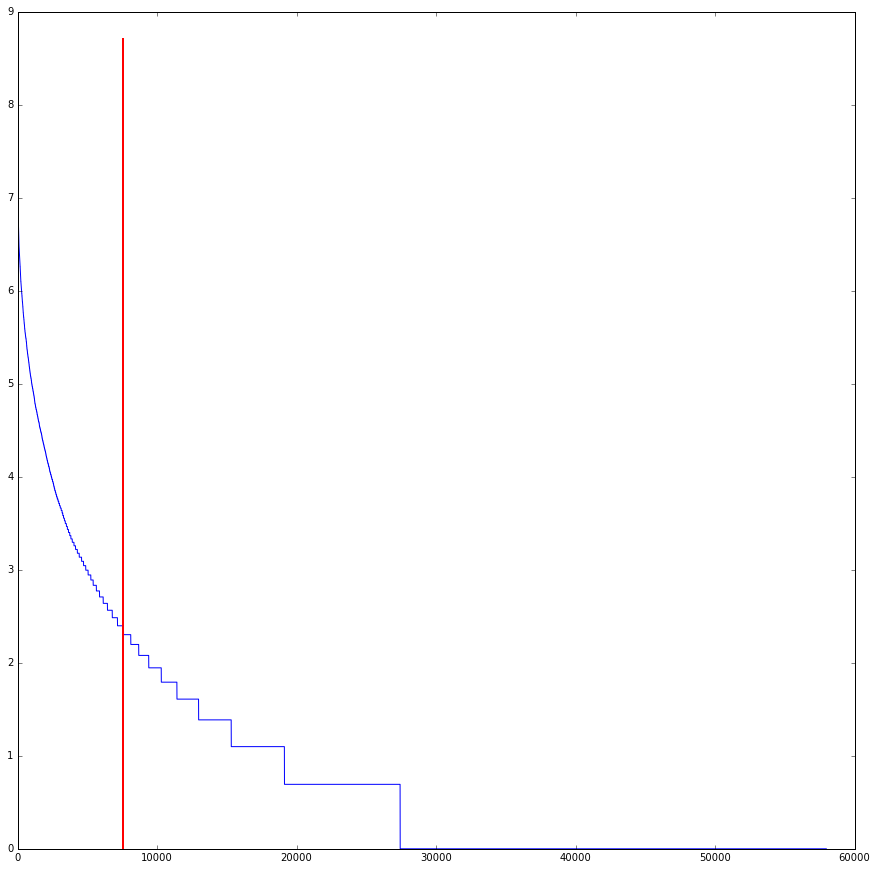

Vectorizing corpus
Writing vectorized docs to data/vectors/20_newsgroups_simple.p
Writing tokenized docs to data/mallet/20_newsgroups_simple.txt

Configuring processor with config/processor/20_newsgroups_complex.yml
Terms before removal: 91177
number removed: 2
After removing common terms: 91175
number removed: 79895
After removing rare terms: 11280


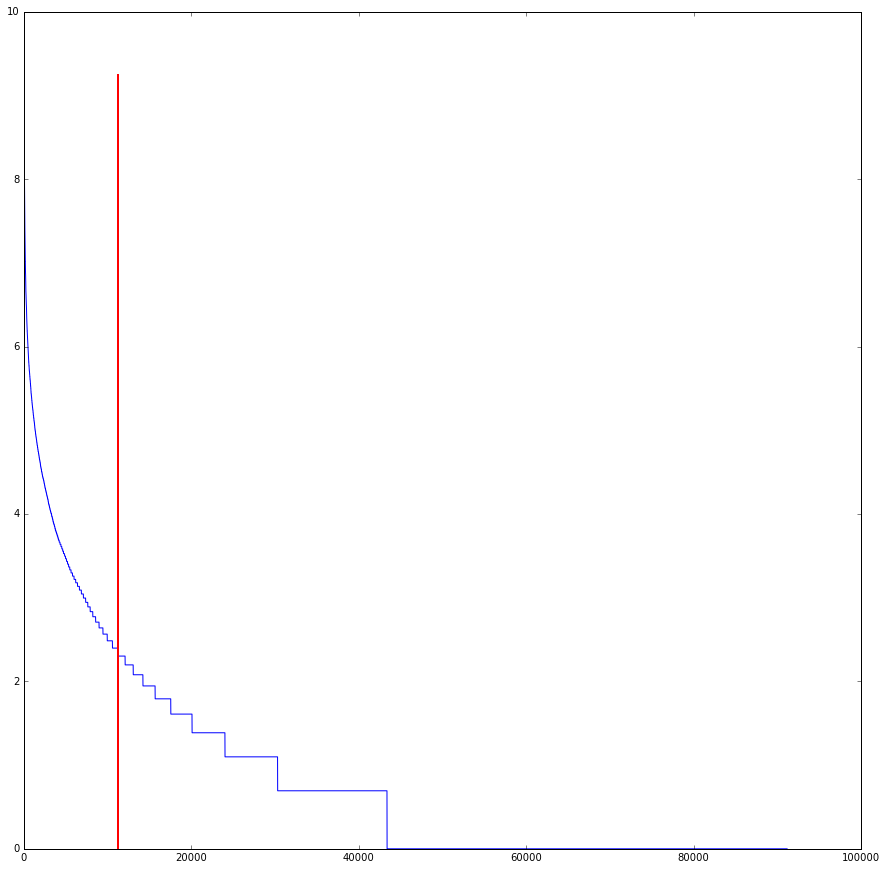

Vectorizing corpus
Writing vectorized docs to data/vectors/20_newsgroups_complex.p
Writing tokenized docs to data/mallet/20_newsgroups_complex.txt



In [12]:
maxDF = 0.85 # 85% of the corpus
minDF = 10 # 20 docs

for config in news_processor_configs:
    basename = os.path.basename(os.path.splitext(config)[0])
    # names of the paths where the data goes
    mallet_path = os.path.join('data','mallet',basename+'.txt')
    vector_path = os.path.join('data','vectors',basename+'.p')
    
    # set up a text processor on the given config file
    print("Configuring processor with {}".format(config))
    processor = calm.processor.Processor(config)
    # and a corpus, specifying to keep the label as position 1 in the tuple representing the doc
    corpus = calm.corpus.BagOfWordsCorpus(processor,textAttribute=2,IDAttribute=0, 
                                          docAttributes=[1],keepTokens=True,keepText=False)
    
    # iterate over docs as tuples (ID, label, text)
    for doc in zip(range(len(newsgroups['data'])), newsgroups['target'],newsgroups['data']):
        # and add each one to the corpus
        corpus.addDoc(doc)
    
    # find the rare and common terms in the corpus
    rareTerms = corpus.lowDFTerms(atMost=minDF)
    commonTerms = corpus.highDFTerms(atLeast=maxDF)
    
    # save the term DF's for plotting
    DFs = np.array(sorted(list(corpus.DF.values()),reverse=True))
    ymax = np.log(DFs[0])
    plt.rcParams['figure.figsize'] = 15,15
    x = range(0,len(DFs))
    plt.plot(x,np.log(DFs),'b-')
    
    # and remove them, reporting numbers as a sanity check
    print("Terms before removal: {}".format(len(corpus.vocab.ID)))
    print("number removed: {}".format(len(commonTerms)))
    corpus.removeTerms(commonTerms)
    xmin = len(commonTerms)
    print("After removing common terms: {}".format(len(corpus.vocab.ID)))
    print("number removed: {}".format(len(rareTerms)))
    corpus.removeTerms(rareTerms)
    xmax = len(DFs) - len(rareTerms)
    print("After removing rare terms: {}".format(len(corpus.vocab.ID)))
    
    # let's see what we cut out
    lower=plt.plot([xmin,xmin],[0,ymax],'r-')
    upper=plt.plot([xmax,xmax],[0,ymax],'r-')
    plt.setp(upper, linewidth=2)
    plt.setp(lower, linewidth=2)
    
    plt.show()
    
    # compute tf-idf vectors and store them, with id's and labels, in a list
    print("Vectorizing corpus")
    vectors = []
    for doc in corpus:
        # ID, label, and sparse vector
        vectors.append((doc.ID,doc[1],corpus.tfidf(doc.ID,normalize = True)))
        
    # write it all to disk
    print("Writing vectorized docs to {}".format(vector_path))
    with open(vector_path,'wb') as outfile:
        pickle.dump((corpus.vocab.token,vectors),outfile)
    print("Writing tokenized docs to {}".format(mallet_path))
    vectors = []
    for doc in corpus:
        # ID, label, and sparse vector
        vectors.append((doc.ID,doc[1],doc.tokens))
    write_MALLET_corpus(vectors,mallet_path)
    
    print()

# Get everything into a form that mallet likes

In [56]:
subprocess.check_output('./'+tokens_to_mallet_script)

b'/home/matt/Git/TextMiningFinal\nConverting test.txt to MALLET\n'